# Import Library

In [1]:
import os
from PIL import Image
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load The Data

In [2]:
def load_images_from_folder(folder_path):
    images = []

    file_names = os.listdir(folder_path)

    random.seed(50)
    random.shuffle(file_names)



    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        images.append(image)

    return images
assign_folder = '/kaggle/input/covid-pneumonia-normal-chest-xray-images'


covid_folder = os.path.join(assign_folder, 'COVID')
normal_folder = os.path.join(assign_folder, 'NORMAL')
pneumonia_folder = os.path.join(assign_folder, 'PNEUMONIA')

covid_images = load_images_from_folder(covid_folder)
normal_images = load_images_from_folder(normal_folder)
pneumonia_images = load_images_from_folder(pneumonia_folder)

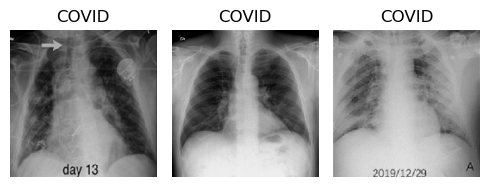

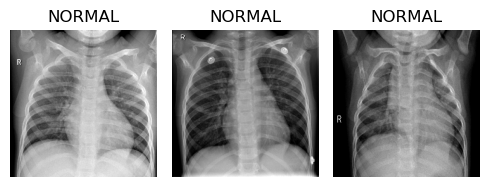

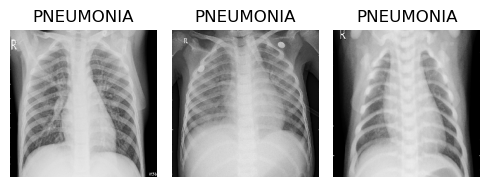

In [5]:
import matplotlib.pyplot as plt
def visualize_images(image_list, title):
    fig, axes = plt.subplots(1, 3, figsize=(5, 4))
    for ax, img in zip(axes, image_list[:3]):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the images
visualize_images(covid_images, 'COVID')
visualize_images(normal_images, 'NORMAL')
visualize_images(pneumonia_images, 'PNEUMONIA')


In [6]:
def count_images_in_folder(folder_path):
    file_names = os.listdir(folder_path)
    num_images = len(file_names)
    return num_images

covid_folder = os.path.join(assign_folder, 'COVID')
normal_folder = os.path.join(assign_folder, 'NORMAL')
pneumonia_folder = os.path.join(assign_folder, 'PNEUMONIA')

covid_count = count_images_in_folder(covid_folder)
normal_count = count_images_in_folder(normal_folder)
pneumonia_count = count_images_in_folder(pneumonia_folder)

print("COVID Images Count:", covid_count)
print("NORMAL Images Count:", normal_count)
print("PNEUMONIA Images Count:", pneumonia_count)

COVID Images Count: 1626
NORMAL Images Count: 1802
PNEUMONIA Images Count: 1800


# Strarified The Split Data

In [7]:
def stratified_split_dataset(images, labels, split_ratios, random_state=42):
    train_images, remaining_images, train_labels, remaining_labels = train_test_split(
        images, labels, train_size=split_ratios[0], stratify=labels, random_state=random_state)

    val_images, test_images, val_labels, test_labels = train_test_split(
        remaining_images, remaining_labels, train_size=0.5, stratify=remaining_labels, random_state=random_state)

    return train_images, val_images, test_images, train_labels, val_labels, test_labels
covid_labels = [0] * len(covid_images)
normal_labels = [1] * len(normal_images)
pneumonia_labels = [2] * len(pneumonia_images)

all_images = covid_images + normal_images + pneumonia_images
all_labels = covid_labels + normal_labels + pneumonia_labels

split_ratios = [0.8, 0.1, 0.1]
random_seed = 42  

train_images, val_images, test_images, train_labels, val_labels, test_labels = stratified_split_dataset(
    all_images, all_labels, split_ratios, random_state=random_seed)
# Count the number of images in each class
train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)
test_class_counts = np.bincount(test_labels)


# Print the amount of train/val/test class

In [8]:
print("Number of images in each class:")

# For COVID
print("COVID:")
print("Train:", train_class_counts[0])
print("Validation:", val_class_counts[0])
print("Test:", test_class_counts[0])
print()  # Newline for separation

# For Normal
print("Normal:")
print("Train:", train_class_counts[1])
print("Validation:", val_class_counts[1])
print("Test:", test_class_counts[1])
print()  # Newline for separation

# For Pneumonia
print("Pneumonia:")
print("Train:", train_class_counts[2])
print("Validation:", val_class_counts[2])
print("Test:", test_class_counts[2])



Number of images in each class:
COVID:
Train: 1301
Validation: 162
Test: 163

Normal:
Train: 1441
Validation: 181
Test: 180

Pneumonia:
Train: 1440
Validation: 180
Test: 180


# Classify by using CNN model

In [9]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)


        self.fc1 = nn.Linear(128 * 10 * 10, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)


        x = x.view(-1, 128 * 10 * 10)


        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)

        x = self.fc2(x)

        return x


input_shape = (3, 100, 100)
num_classes = 3


model = CNNModel(input_shape, num_classes)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

resize_transform = transforms.Resize((100, 100))

train_images = [img.convert("RGB") for img in train_images]
val_images = [img.convert("RGB") for img in val_images]
test_images = [img.convert("RGB") for img in test_images]

train_images = [resize_transform(img) for img in train_images]
val_images = [resize_transform(img) for img in val_images]
test_images = [resize_transform(img) for img in test_images]

train_images = torch.stack([transforms.ToTensor()(img) for img in train_images])
val_images = torch.stack([transforms.ToTensor()(img) for img in val_images])
test_images = torch.stack([transforms.ToTensor()(img) for img in test_images])

train_labels = torch.LongTensor(train_labels)
val_labels = torch.LongTensor(val_labels)
test_labels = torch.LongTensor(test_labels)


train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
             
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss_val = criterion(outputs, labels)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Transfer the inputs and labels to the GPU (or CPU if CUDA is not available)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)  
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Call the training function
num_epochs = 30
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# Call the testing function
test_model(model, test_loader)


Epoch 1/30, Train Loss: 0.5605, Train Accuracy: 76.23%
Validation Loss: 0.3280, Validation Accuracy: 89.10%
Epoch 2/30, Train Loss: 0.3302, Train Accuracy: 88.21%
Validation Loss: 0.2364, Validation Accuracy: 91.40%
Epoch 3/30, Train Loss: 0.2557, Train Accuracy: 91.37%
Validation Loss: 0.1814, Validation Accuracy: 94.26%
Epoch 4/30, Train Loss: 0.2156, Train Accuracy: 92.61%
Validation Loss: 0.1776, Validation Accuracy: 92.35%
Epoch 5/30, Train Loss: 0.1917, Train Accuracy: 93.50%
Validation Loss: 0.1656, Validation Accuracy: 94.84%
Epoch 6/30, Train Loss: 0.1654, Train Accuracy: 94.50%
Validation Loss: 0.1094, Validation Accuracy: 96.37%
Epoch 7/30, Train Loss: 0.1408, Train Accuracy: 95.38%
Validation Loss: 0.1406, Validation Accuracy: 95.03%
Epoch 8/30, Train Loss: 0.1461, Train Accuracy: 95.17%
Validation Loss: 0.0989, Validation Accuracy: 97.13%
Epoch 9/30, Train Loss: 0.1228, Train Accuracy: 95.98%
Validation Loss: 0.1104, Validation Accuracy: 96.18%
Epoch 10/30, Train Loss: 0.1

# Result Evaluation

In [12]:
def test_model(model, test_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    
    return true_labels, pred_labels


# Calculate the recall/precision

In [21]:
import numpy as np
def calculate_recall_precision(confusion_matrix):
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    return recall, precision
recall, precision = calculate_recall_precision(cm)
for i, label in enumerate(labels):
    print(f"Class: {label}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"Precision: {precision[i]:.4f}")
    print()


Class: COVID
Recall: 0.9816
Precision: 1.0000

Class: NORMAL
Recall: 0.9722
Precision: 0.9563

Class: PNEUMONIA
Recall: 0.9611
Precision: 0.9611

